# EDA Notebook for Tokenizer

In [1]:
import pandas as pd
import numpy as np
import os
from datasets import Dataset, load_dataset, DatasetDict
from transformers import BertTokenizer, BertModel
import seaborn as sns
import matplotlib.pyplot as plt


/home/dmacres/anaconda3/envs/gendis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the datasets and investigate

In [79]:
train = load_dataset('dmacres/mimiciii-hospitalcourse', split = 'train')
valid = load_dataset('dmacres/mimiciii-hospitalcourse', split = 'validation')
test = load_dataset('dmacres/mimiciii-hospitalcourse', split = 'test')

In [7]:
train

Dataset({
    features: ['subject_id', 'hadm_id', 'notes', 'target_text'],
    num_rows: 24993
})

In [9]:
train['notes'][0][0]

{'category': 'Nursing/other',
 'chartdate': '2170-06-17 00:00:00.000',
 'description': 'Report',
 'row_id': 1516710,
 'text': 'Pt to SICU-R sided SDH, one week history of ataxia, states he may have hit his head on the "bulk head", c/o of H/A and took asa, to OSH where CT showed right subdural hematoma was then transfered to [**Hospital1 95**], PMH HTN, NIDDM, hypercholesteromia, drinks [**1-1**] [**Doctor Last Name **] [**Doctor Last Name 7171**] per day\n\nOn arrival to SICU: pt [**Name (NI) **]3, MAEW R and L side full stregth, denies H/A, PERLLA, smile/tongue midline, denies h/a, denies dizzyness\nCV-VSS MP SB, CSM WNL HS S1 S2 RRR\nResp-LS clear A/P Sao2 97 RA\nGI-NPO, abs round soft distended +BS\nGU-voids\nSkin-intact\n\nPlan-pt to OR for Burr holes\n'}

## Test mapping function on dataset

In [14]:
def test_map(example):
    for idx, note in enumerate(example['notes']):
        example['notes'][idx]['row_idx2'] = int(example['notes'][idx]['row_id'])*2
    return example

In [15]:
t = train.map(test_map)
t[0]

Map: 100%|███████████████████████████████████████████████████| 24993/24993 [00:09<00:00, 2757.03 examples/s]


## Load common bert-base-uncased tokenizer and test it out

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [40]:
text = "hello world, this is a test"
tokenized_text = tokenizer.encode_plus(text, return_token_type_ids = False, return_attention_mask = False, return_length=True)

In [41]:
tokenized_text

{'input_ids': [101, 7592, 2088, 1010, 2023, 2003, 1037, 3231, 102], 'length': 9}

In [36]:
vocab = tokenizer.get_vocab()
id2vocab = {val:key for key,val in vocab.items()}

In [37]:
input_vocab = [id2vocab[id] for id in tokenized_text['input_ids']]
input_vocab

['[CLS]', 'hello', 'world', ',', 'this', 'is', 'a', 'test', '[SEP]']

## Create a function to tokenize and get metrics and map it to the dataset splits

In [80]:
def tokenize_and_get_metrics(example):
    total_token_length = 0
    
    for idx, note in enumerate(example['notes']):
        tokenized_dict = tokenizer.encode_plus(note['text'], return_token_type_ids = False, return_attention_mask = False, return_length=True)
        total_token_length += tokenized_dict['length']
        example['notes'][idx] = {**note, **tokenized_dict}
        
    example['n_notes'] = len(example['notes'])
    example['total_token_length'] = total_token_length
    
    target_tokenized_dict = tokenizer.encode_plus(example['target_text'], return_token_type_ids = False, return_attention_mask = False, return_length=True)
    target_tokenized_dict = {f"target_{key}":val for key,val in target_tokenized_dict.items()}

    example = {**example, **target_tokenized_dict}
    
    return example

In [81]:
train_meta = train.map(tokenize_and_get_metrics)

Map: 100%|█████████████████████████████████████████████████████| 24993/24993 [30:09<00:00, 13.81 examples/s]


NameError: name 'validation' is not defined

In [87]:
valid_meta = valid.map(tokenize_and_get_metrics)

Map: 100%|███████████████████████████████████████████████████████| 5356/5356 [06:49<00:00, 13.09 examples/s]


In [88]:
test_meta = test.map(tokenize_and_get_metrics)

Map: 100%|███████████████████████████████████████████████████████| 5356/5356 [06:28<00:00, 13.78 examples/s]


## Push the mapped dataset to Hugging Face Hub becuase this took a while to make

In [92]:
meta_dataset = DatasetDict({
    "train": train_meta,   # split1_ds is an instance of `datasets.Dataset`
    "validation": valid_meta,
    "test": test_meta,
})
meta_dataset.push_to_hub("mimiciii-hospitalcourse-bert-base-uncased-tokenized", private = True)

Pushing dataset shards to the dataset hub: 100%|██████████████████████████████| 2/2 [03:04<00:00, 92.03s/it]


## Plot the results

In [93]:
def make_plot(dataset, split):
    n_notes = [x['n_notes'] for x in dataset]
    n_tokens = [x['total_token_length'] for x in dataset]
    
    g = sns.JointGrid(x = n_notes, y = n_tokens, height = 10)
    plot = g.plot(sns.scatterplot, sns.histplot)
    plot.set_axis_labels('Number of Notes', 'Number of Total Tokens', fontsize=8, fontweight = 'bold')
    plot.fig.suptitle(f'Total Tokens vs. Number of Notes for {split} Set', fontsize=15, fontweight = 'bold')

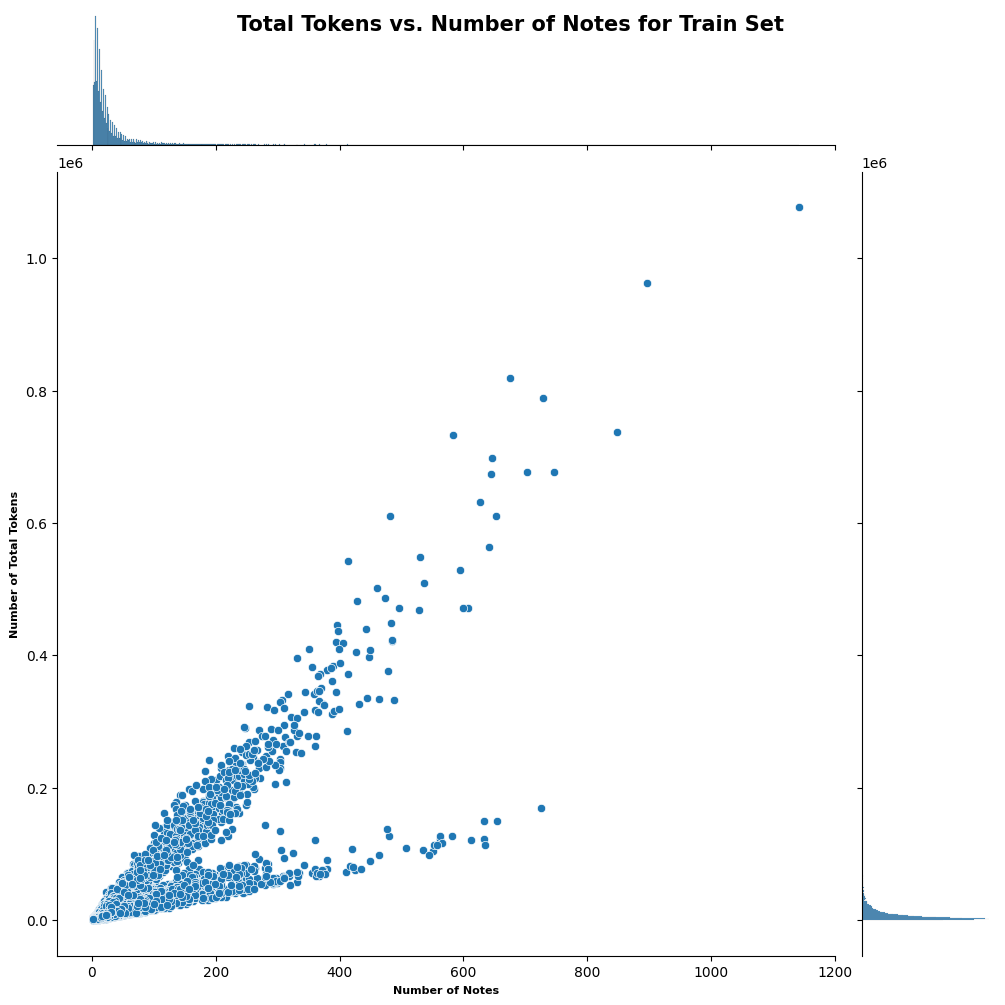

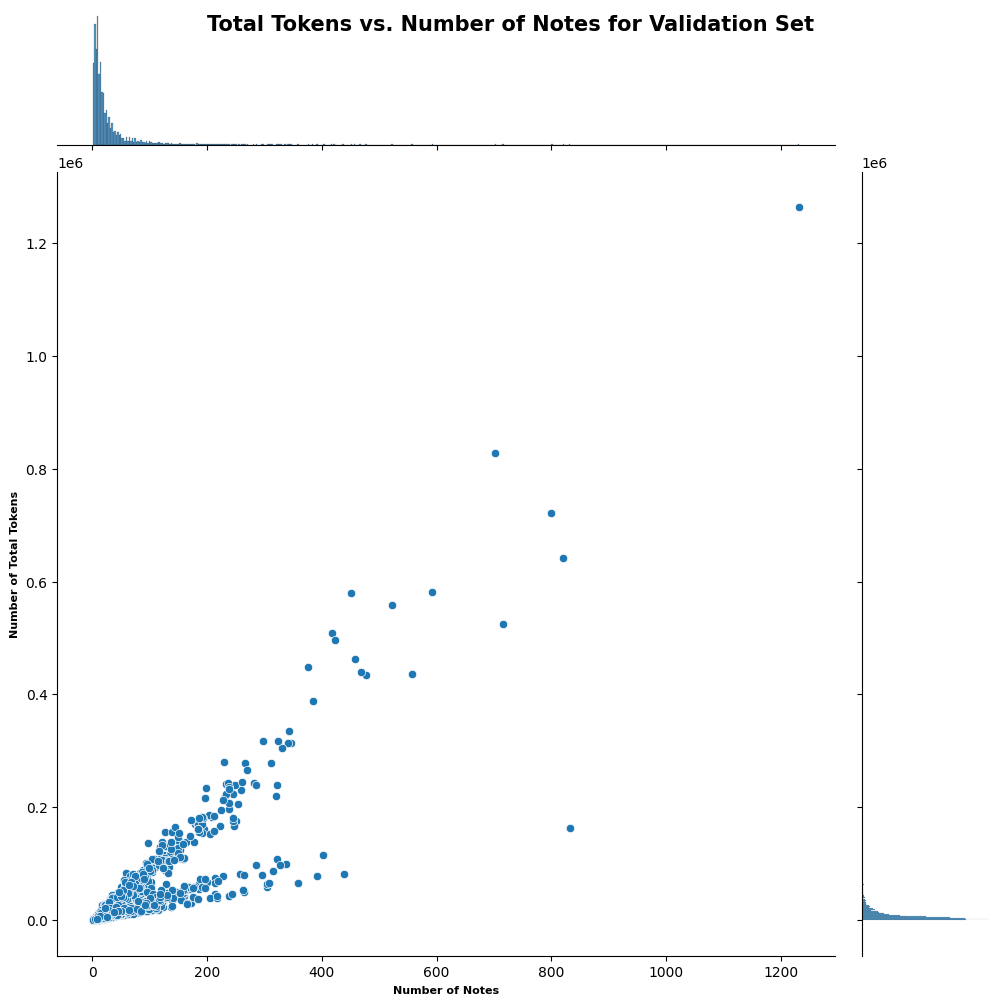

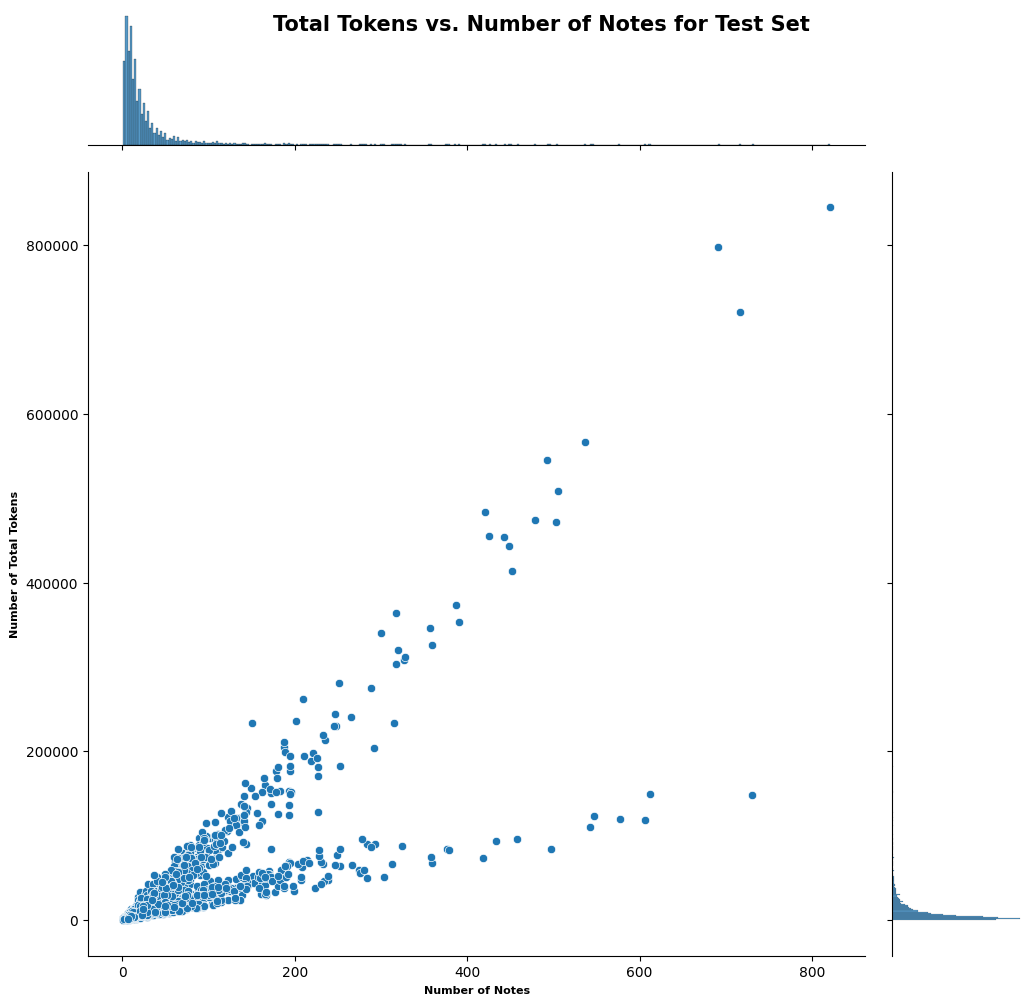

In [94]:
for dataset, split in ((train_meta, 'Train'), (valid_meta, 'Validation'), (test_meta, 'Test')):
    make_plot(dataset, split)

In [101]:
def make_all_plots(dataset, split):
    n_notes = [x['n_notes'] for x in dataset]
    n_tokens = [x['total_token_length'] for x in dataset]
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    sns.histplot(x = n_tokens, ax = axes[0])
    axes[0].set_xlim(0,20000)
    axes[0].set_title('Number of Total Tokens per Patient Histogram')
    axes[0].set_xlabel('Number of Total Tokens')
    axes[0].set_ylabel('Counts')

    sns.regplot(x = n_notes, y = n_tokens, ax = axes[1], line_kws={"color": "green"})
    axes[1].set_title('Number of Total Tokens vs. Number of Notes per Patient')
    axes[1].set_xlabel('Number of Notes')
    axes[1].set_ylabel('Number of Total Tokens')
    
    sns.histplot(x = n_notes, ax = axes[2])
    axes[2].set_xlim(0,400)
    axes[2].set_title('Number of Notes per Patient Histogram')
    axes[2].set_xlabel('Number of Notes')
    axes[2].set_ylabel('Counts')

    fig.suptitle(f"{split} Set", fontsize = 16)
    plt.show()

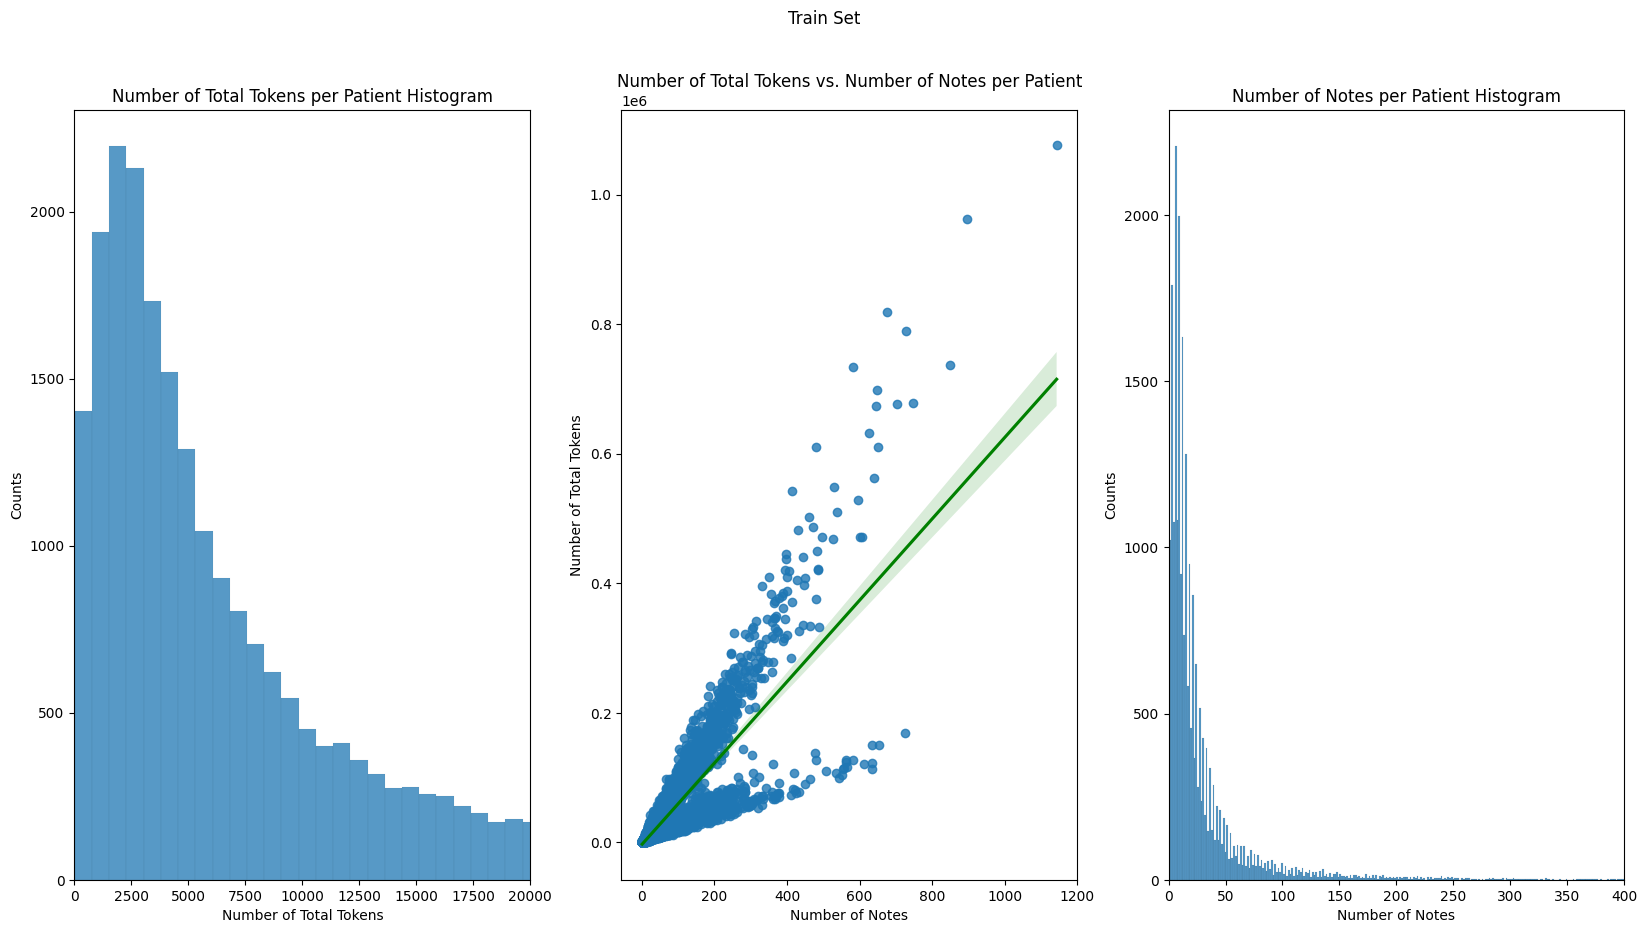

In [105]:
make_all_plots(train_meta, 'Train')

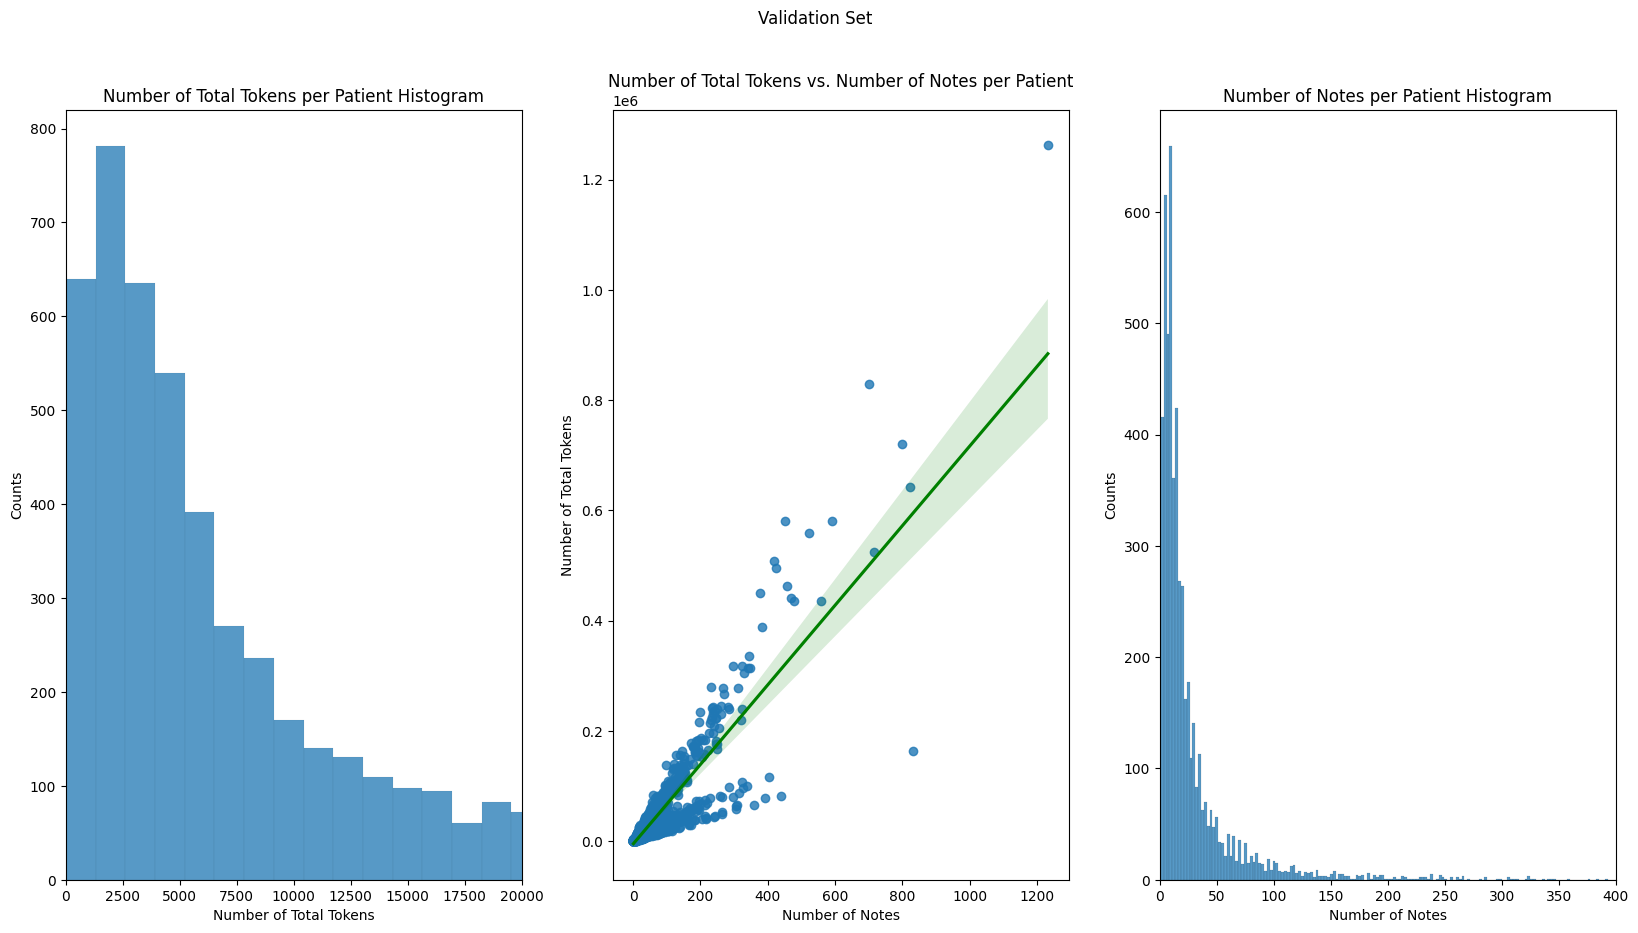

In [104]:
make_all_plots(valid_meta, 'Validation')

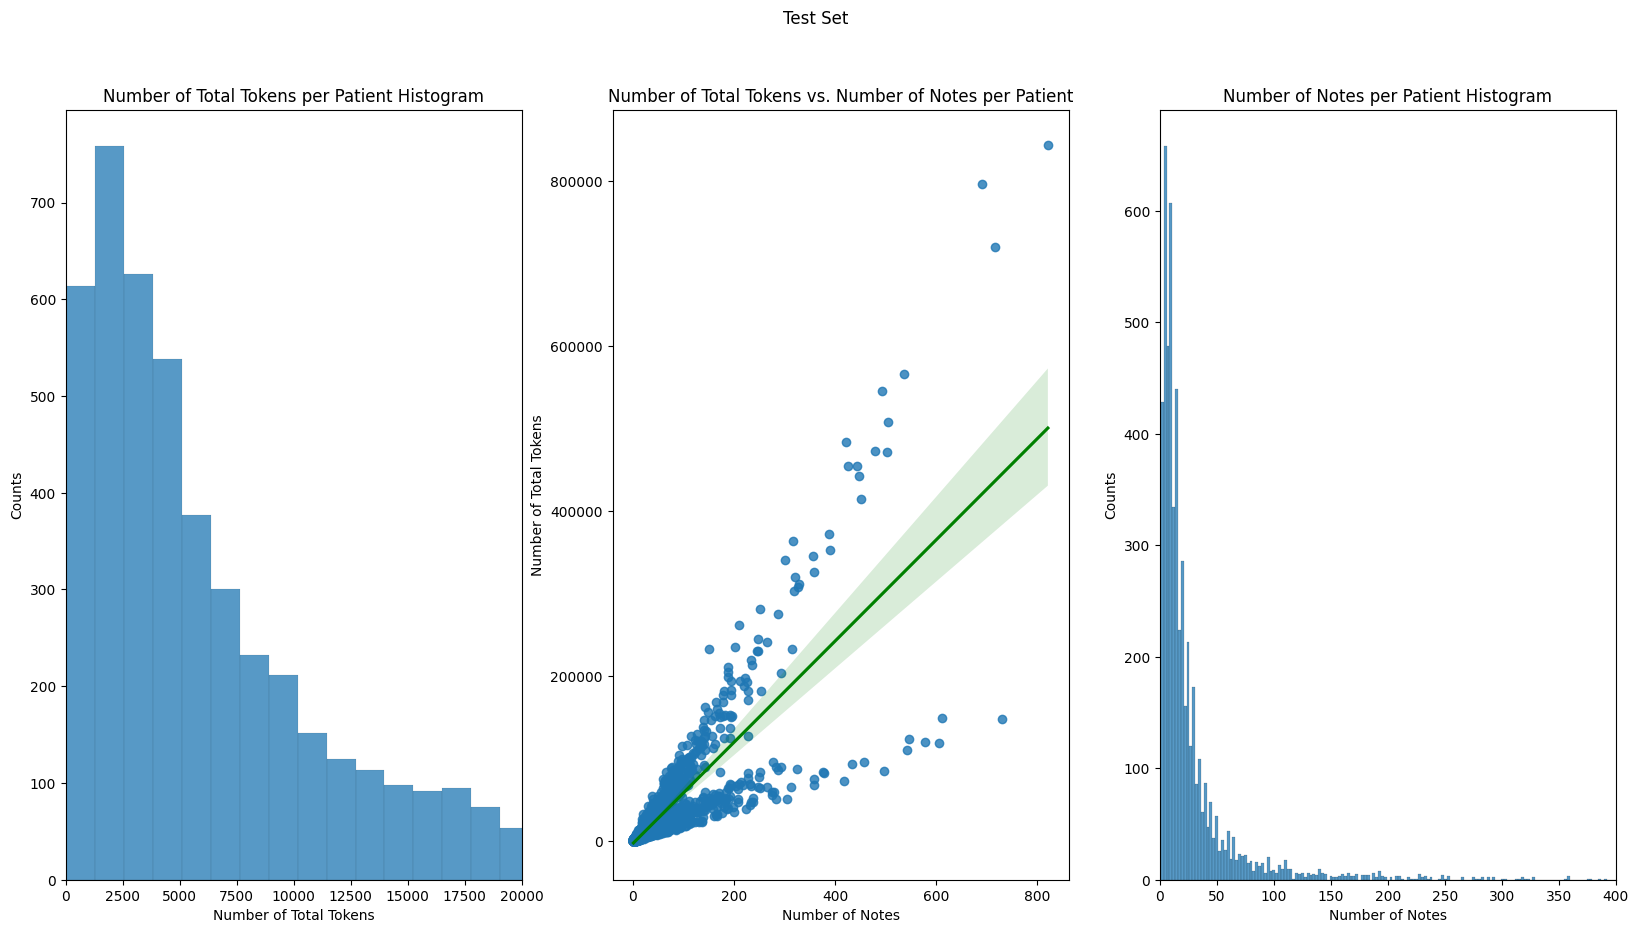

In [103]:
make_all_plots(test_meta, 'Test')

## Context lengths for models of interest
- GPT2-XL: 1024 (https://huggingface.co/gpt2-xl/blob/main/config.json)
- T5-Large: 512 (https://huggingface.co/t5-large/blob/main/config.json)
- BART-Large-XSum: 1024 (https://huggingface.co/facebook/bart-large-xsum/blob/main/config.json)??
- Pegasus-XSum: 512 (https://huggingface.co/google/pegasus-xsum/blob/main/config.json)??

Obviously we have an issue... Most of our notes have a combined total token length greater than the models' context lengths! The questions become:
1. How can we train a summarizatiuon model where the total length is significantly longer than the model's context length?
2. Can we even train this type of Model (especially since we are limited with a single GPU)?
3. Will we need to discard training and just focus on a recursive technique that generates the best summarization?

Some resources/things to think about:
1. https://discuss.huggingface.co/t/summarization-on-long-documents/920?page=2
2. https://aclanthology.org/2022.acl-long.474.pdf
3. https://arxiv.org/pdf/2109.10862v2.pdf

It is likely we may have to change the scope of this project...

In [2]:
dataset_name = "dmacres/mimiciii-hospitalcourse-bert-base-uncased-tokenized"
train = load_dataset(dataset_name, split = 'train')
valid = load_dataset(dataset_name, split = 'validation')
test = load_dataset(dataset_name, split = 'test')













Generating test split: 100%|███████████████████████████████████| 5356/5356 [00:04<00:00, 1078.04 examples/s]


In [5]:
test

Dataset({
    features: ['subject_id', 'hadm_id', 'notes', 'target_text', 'n_notes', 'total_token_length', 'target_input_ids', 'target_length'],
    num_rows: 5356
})

In [21]:
def plot_target_lengths(dataset, split):
    target_lengths = [x['target_length'] for x in dataset]
    the_mean = round(np.mean(target_lengths), 3)
    the_median = round(np.median(target_lengths), 3)
    fig = plt.figure(figsize = (10,10))
    sns.histplot(x=target_lengths).set(title = f'Histogram of Target Summary Lengths for {split} Set', xlabel = 'Target Summary Length', ylabel = 'Count')
    plt.axvline(x=the_mean, color='red', linestyle='--', label=f'Mean ({the_mean})')
    plt.axvline(x=the_median, color='black', linestyle='--', label=f'Median ({the_median})')
    plt.legend()

# plot.set(title = 'Discharge Summary Word Counts vs. Number of Note Events', xlabel = 'Number of Note Events', ylabel = 'Word Counts')

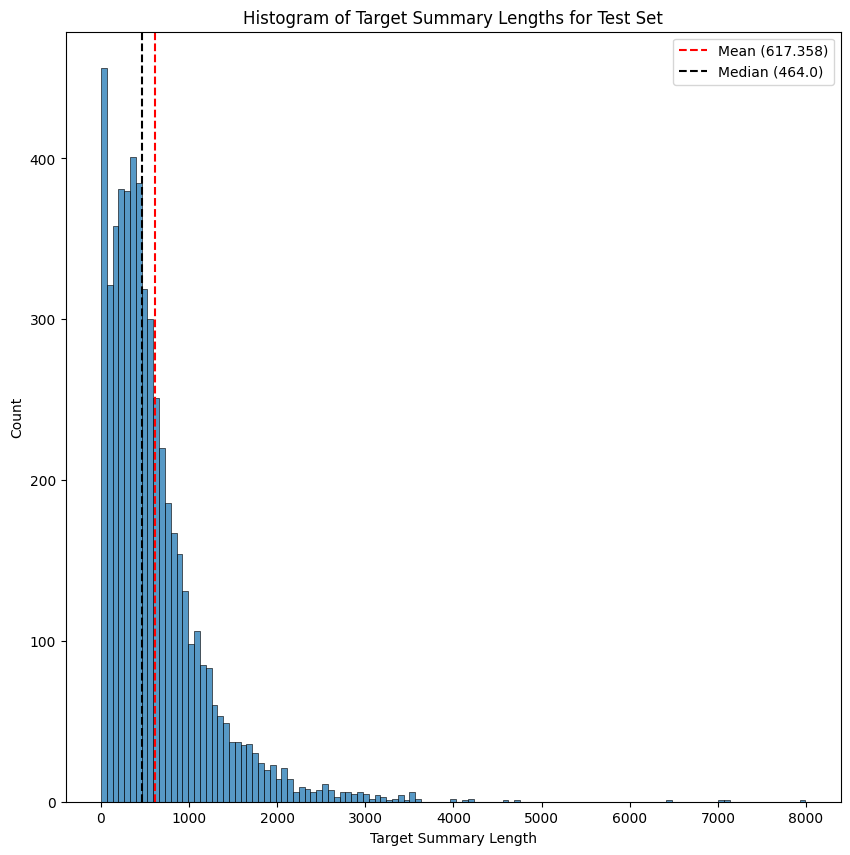

In [22]:
plot_target_lengths(test, 'Test')

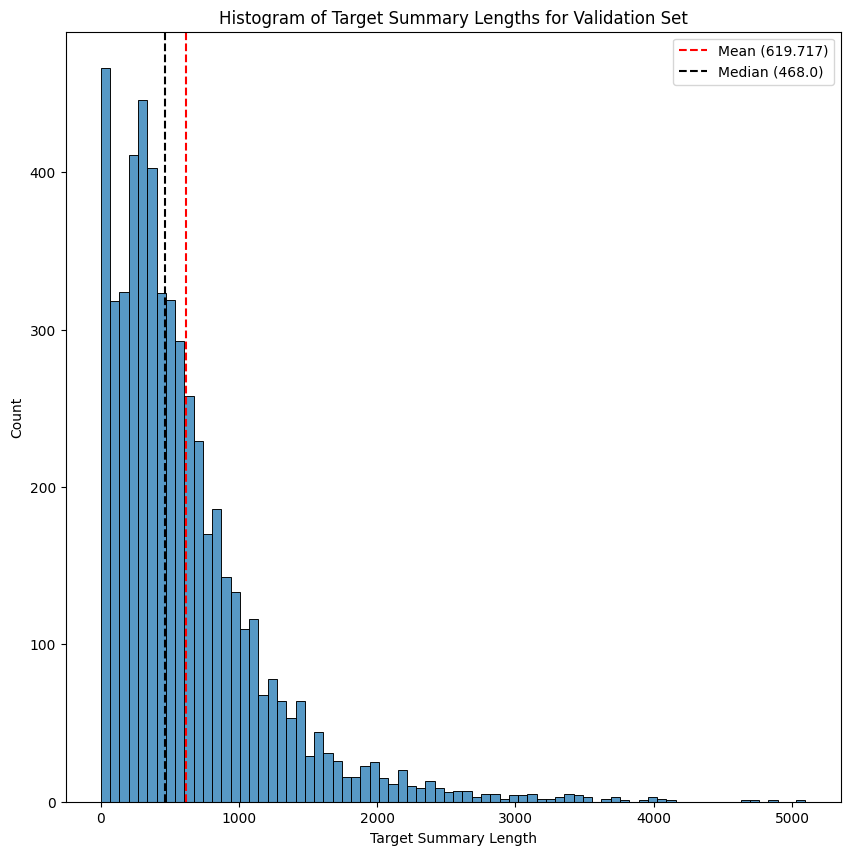

In [23]:
plot_target_lengths(valid, 'Validation')

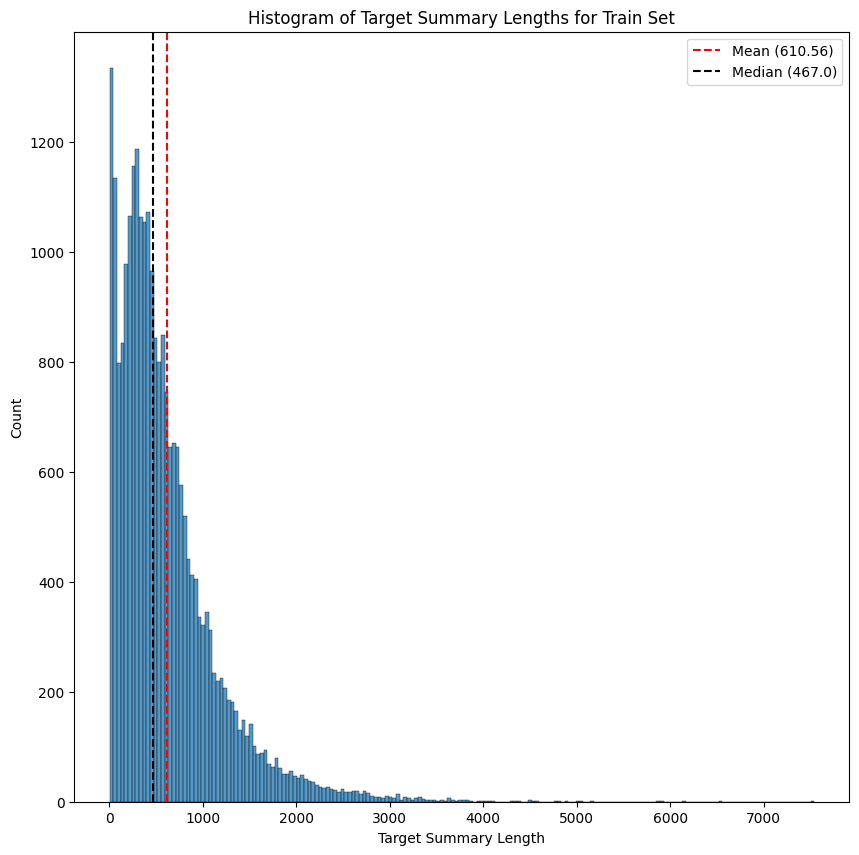

In [24]:
plot_target_lengths(train, 'Train')